In [2]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np
from numba import njit
from SudokuLib import *

0.66192204
Wall time: 66.6 ms


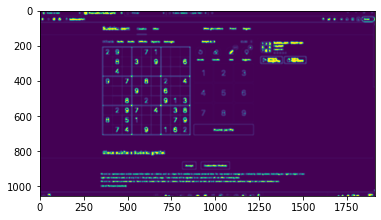

In [3]:
%%time
page = np.float32(plt.imread("s0.png"))[:,:,1]
h, w = page.shape
img = np.abs(page[1:] - page[:-1])[:, :-1] + np.abs(page[:, 1:] - page[:, :-1])[:-1]  # detect difference in pixel brightness
img = blurFast(img, 9)
#img = cv2.blur(img, (9, 9))
print(np.max(img))
img[img > 0.2] = 1
plt.imshow(img)

Wall time: 674 ms


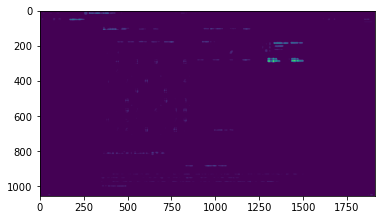

In [4]:
%%time
lines = findLines(img)
#lines = blur(lines, 7)
plt.imshow(lines)

In [21]:
rows = np.sum(lines, axis = 0)
rows[rows < np.max(rows)/2] = 0
cols = np.sum(lines, axis = 1)
cols[cols < np.max(cols)/2] = 0

coords = [ffv(rows), w-ffv(reversed(rows)), ffv(cols), h-ffv(reversed(cols))]
print(coords)

[353, 860, 206, 713]


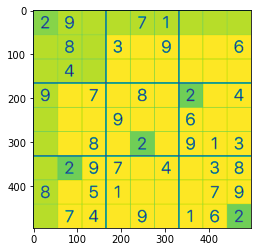

In [5]:
crop = page[coords[2]+3:coords[3]-5, coords[0]+3:coords[1]-5]
plt.imshow(crop)

In [101]:
numbers = []
for x1 in range(9):
    for y1 in range(9):
        x = x1*crop.shape[1]//9
        y = y1*crop.shape[0]//9
        cell = crop[x:x+crop.shape[1]//9, y:y+crop.shape[0]//9]
        cell = cell[5:-5, 5:-5]
        cell = cv2.resize(cell, (24, 24))
        cell = cv2.blur(cell, (3, 3))
        cell[cell < 0.7] = 0
        numbers.append(cell)
        #numbers.append(crop[x:x+crop.shape[1]//9, y:y+crop.shape[0]//9])
n = 0

0 0.0


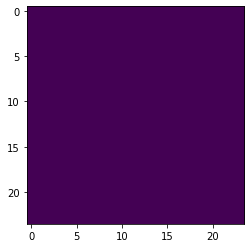

In [120]:
import random
#plt.imshow(numbers[random.randint(0, 80)])
#numbers = numbers.view(-1, 24, 24)
#numbers = numbers.cpu().numpy()
#print(numbers.shape)
plt.imshow(numbers[n])
print(pred.argmax(1)[n].item(), pred[n][pred.argmax(1)[n]].item())
n+=1

In [18]:
import torch
import torch.nn.functional as F
import pickle

def predictCells(data):
    with open("params99710.pkl", 'rb') as f:
        params = pickle.load(f)
    w1, b1, w2, b2, w3, b3, k1, k2, k3, w4, b4 = params
    l = data.shape[0]
    c1 = F.conv2d(data, k1)
    c2 = F.conv2d(c1, k2)
    p1 = F.max_pool2d(c2, (2, 2))
    c3 = F.conv2d(p1, k3)
    p2 = F.max_pool2d(c3, (2, 2))
    n1 = torch.tanh(p2.view(l, -1) @ w1 + b1)
    n2 = torch.tanh(n1 @ w2 + b2)
    n3 = torch.tanh(n2 @ w3 + b3)
    out = F.softmax(n3 @ w4 + b4, 0)
    return out

numbers = torch.tensor(np.array(numbers)).view(-1, 1, 24, 24).to(torch.device("cuda:0"))
pred = predictCells(numbers)
pred[numbers.min(2)[0].min(2)[0][:,0] > 0.7] = 0

FileNotFoundError: [Errno 2] No such file or directory: 'params99710.pkl'

In [19]:
print(pred.argmax(1).view(9, 9))

tensor([[2, 9, 0, 0, 7, 1, 0, 0, 0],
        [0, 8, 0, 3, 0, 9, 0, 0, 6],
        [0, 4, 0, 0, 0, 0, 0, 0, 0],
        [9, 0, 7, 0, 8, 0, 2, 0, 4],
        [0, 0, 0, 9, 0, 0, 6, 0, 0],
        [0, 0, 8, 0, 2, 0, 9, 1, 3],
        [0, 2, 9, 7, 0, 4, 0, 3, 8],
        [8, 0, 5, 1, 0, 0, 0, 7, 9],
        [0, 7, 4, 0, 9, 0, 1, 6, 2]], device='cuda:0')


In [10]:

import numpy as np
import time

def checkDoubles(s): # TRUE if FOUND
    list = []
    for element in s:
        if element in list and element != 0:
            return True
        else:
            list.append(element)

def checkBoxes(s):
    s = np.array(s)
    for i in range(3):
        for j in range(3):
            if checkDoubles(s[i*3:i*3+3, j*3:j*3+3].flatten().tolist()):
                return False
    return True

def checkColumns(s):
    for i in range(9):
        if checkDoubles(s[i]):
            return False
    return True
        
def checkRows(s):
    for i in range(9):
        if checkDoubles(np.array(s)[:,i].tolist()):
            return False
    return True
        
        
def check(s):
    try: s = s.tolist()
    except: pass
    
    if checkBoxes(s) and checkColumns(s) and checkRows(s):
        return True # OK
    else:
        return False


m = np.array(pred.argmax(1).view(9, 9).cpu())

def possibilities(m):
    m = np.array(m)
    poss = []
    test = m.copy()
    for i in range(9):
        poss.append([])
        test = m.copy()
        for j in range(9):
            poss[-1].append([])
            test = m.copy()
            if test[i][j] == 0:
                for test[i][j] in range(1,10):
                    if check(test):
                        poss[-1][-1].append(test[i][j])
    return poss
            
            
def solve(m, poss):
    p = np.argmin(np.array(m))
    pos = [p//9, p%9]
    board = m.copy()
    for i in poss[pos[0], pos[1]]:
        if i.size == 0: break
        board[pos[0], pos[1]] = i
        if check(board):
            if np.min(board) == 1: # To make it work make 80 the last zero 
                return board
            solution = solve(board.copy(), poss)
            if np.min(solution) == 1: return solution
        

start = time.time()
poss = np.array(possibilities(m))
print(solve(np.array(m), poss))

[[2 9 6 8 7 1 3 4 5]
 [5 8 1 3 4 9 7 2 6]
 [7 4 3 2 5 6 8 9 1]
 [9 1 7 6 8 3 2 5 4]
 [4 3 2 9 1 5 6 8 7]
 [6 5 8 4 2 7 9 1 3]
 [1 2 9 7 6 4 5 3 8]
 [8 6 5 1 3 2 4 7 9]
 [3 7 4 5 9 8 1 6 2]]


C:\Users\lucam\AppData\Local\Temp/ipykernel_6536/205235439.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  poss = np.array(possibilities(m))


In [205]:
numbers.min(2)[0].min(2)[0][:,0] 

tensor([0.0000, 0.0000, 0.9216, 0.9216, 0.0000, 0.0000, 0.9216, 0.9216, 0.9216,
        0.9216, 0.0000, 0.9216, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000,
        0.9216, 0.0000, 0.9216, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        0.9216, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        0.9216, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.9216, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000,
        0.9216, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')